#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cross Validation

In past colabs we have practiced dividing our data into testing and training sets in order to evaluate the performance of our models. In some cases, especially when there is limited data available, we can't be too sure that our model isn't overfitting.

Cross validation is a [resampling](https://en.wikipedia.org/wiki/Resampling_(statistics)) technique that we use in machine learning to measure the quality of our model while by running multiple iterations of training and testing using different subsets of the data.

The most common algorithm used for cross validation in machine learning is k-fold cross validation. This colab will focus primarily on k-fold cross validation.


## Overview

### Learning Objectives
 
* Understand cross validation and how it is different from simple test/train splits.
* Build a synthetic column.
* Implement k-fold cross validation.
* Use k-fold cross validation libraries.
* Apply stratification to samples.


### Prerequisites

* Linear Regression with scikit-learn

### Estimated Duration

60 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 6 points available. The grading scale will be 3 points.

## Obtain and Prepare the Data

### Obtain the Data

Montgomery County Maryland provides [salary data](https://catalog.data.gov/dataset?tags=salary-and-gender) for government employees by year. For this colab we will use the 2017 dataset.

The code box below downloads the dataset and saves it in a file called 'Employee_Salaries_-_2017.csv'.

In [2]:
import urllib.request
import os

url = 'https://data.montgomerycountymd.gov/api/views/2qd6-mr43/rows.csv?accessType=DOWNLOAD'
file_name = 'Employee_Salaries_-_2017.csv'

urllib.request.urlretrieve(url, file_name)

if file_name not in os.listdir('./'):
  raise Exception(f'{file_name} was not downloaded to the correct directory')

Once the file is downloaded we can read it into a `DataFrame` and take a peek at the first bit of data.

In [3]:
import pandas as pd

salary_data = pd.read_csv(file_name)
salary_data.head()

,Full Name,Gender,Current Annual Salary,2017 Gross Pay Received,2017 Overtime Pay,Department,Department Name,Division,Assignment Category,Employee Position Title,Position Under-Filled,Date First Hired
0,"Aarhus, Pam J.",F,70959.79,71316.72,0.00,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,NaN,09/22/1986
1,"Aaron, Marsha M.",F,110359.00,108040.82,0.00,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Supervisory Social Worker,NaN,11/19/1989
2,"Ababio, Godfred A.",M,55950.24,62575.19,7649.19,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,NaN,05/05/2014
3,"Ababu, Essayas",M,95740.00,96055.94,0.00,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,NaN,03/05/2007
4,"Abbamonte, Drew B.",M,74732.00,98736.78,23468.73,POL,Department of Police,PSB 6th District Special Assignment Team,Fulltime-Regular,Police Officer III,NaN,07/16/2007


### Build a Synthetic Column

Let's take a look at just the column names and data types.

In [4]:
salary_data.dtypes

Full Name                   object
Gender                      object
Current Annual Salary      float64
2017 Gross Pay Received    float64
2017 Overtime Pay          float64
Department                  object
Department Name             object
Division                    object
Assignment Category         object
Employee Position Title     object
Position Under-Filled       object
Date First Hired            object
dtype: object

The only numeric columns are related to pay, but there is one other column that looks like it might could be converted to a number and predictive of pay: 'Date First Hired'. 

In [5]:
salary_data['Date First Hired'].sample(10)

1688    07/11/2016
3016    06/15/2015
2568    06/28/1999
4121    02/09/2015
7460    01/09/1994
9135    09/06/1988
4435    01/09/2017
7073    03/22/2004
4807    03/19/2007
9097    10/16/2017
Name: Date First Hired, dtype: object

We can convert the dates from a string to a date using Panda's `to_datetime` function.

In [6]:
pd.to_datetime(salary_data['Date First Hired']).sample(10)

150    2008-03-17
7386   2007-09-17
8282   2002-09-03
9058   2016-12-12
8220   1993-07-26
2535   1997-11-17
74     1989-04-10
2871   1999-08-16
5219   2004-09-07
4684   1985-10-21
Name: Date First Hired, dtype: datetime64[ns]

It would be useful to convert this data to a numeric variable. Since we know we are working with data from 2017 we can choose some date in 2017 and subtract the first hire date from it creating a 'Tenure' column.
 
Since some employees were likely hired in 2017 we don't want to use the first of the year. For simplicity's sake we will simply subtract the first hired date from January 1st 2018.

In [7]:
salary_data['Tenure'] = ((pd.to_datetime('01/01/2018') - pd.to_datetime(salary_data['Date First Hired'])).apply(lambda td: td.days)).astype('int64')
salary_data[['Date First Hired', 'Tenure']].sample(10)

,Date First Hired,Tenure
2839,08/16/2004,4886
290,08/26/2013,1589
4758,01/09/2017,357
4603,01/14/2013,1813
3549,02/14/2000,6531
2694,02/14/2011,2513
3114,01/04/2011,2554
7634,12/13/2004,4767
8471,01/12/2015,1085
3703,08/17/1998,7077


Let's also describe the data and check out the distribution of our new 'Tenure' column.

In [8]:
salary_data['Tenure'].describe()

count     9398.000000
mean      4696.393169
std       3441.486875
min          6.000000
25%       1617.000000
50%       4263.000000
75%       6825.000000
max      19086.000000
Name: Tenure, dtype: float64

We can see that the minimum tenure is 6 days and that the 50th percentile is 4263 days, which is just over 11.5 years. That doesn't seem too crazy for a government job.
 
Check out that max value though! 19086 days, which is just over 52 years.
 
Let's look closer.

In [9]:
salary_data[salary_data['Tenure'] == 19086]

,Full Name,Gender,Current Annual Salary,2017 Gross Pay Received,2017 Overtime Pay,Department,Department Name,Division,Assignment Category,Employee Position Title,Position Under-Filled,Date First Hired,Tenure
4209,"Jann, Judith A.",F,103381.1,102019.1,0.0,HHS,Department of Health and Human Services,Area Health Centers,Fulltime-Regular,Community Health Nurse II,NaN,09/30/1965,19086


A quick search on the internet brings up [meeting minutes](https://www.montgomerycountymd.gov/HHS-Program/Resources/Files/PHSDocs/COH/June%202016%20approved%20COH%20Minutes--FINAL.pdf) from 2016 where our outlier is being congratulated for 50 years of service to Montgomery County.
 
Our new column seems to be legit.

### Visualize the Data

Our dataset contains salary data for every government employee. This includes a wide range of job roles, each with their own competitive pay ranges.

Let's look at a visualization of salary and tenure.

In [10]:
import matplotlib.pyplot as plt

plt.plot(salary_data['Tenure'], salary_data['Current Annual Salary'], 'b.')
plt.show()

<Figure size 640x480 with 1 Axes>

### Narrow the Problem Scope

This data would be impossible to predict reliably using a linear function. Let's explore the data and see what the most common job roles are. We can then just build a model for that job role.

In [11]:
salary_data.groupby('Employee Position Title')['Tenure'].count().sort_values(ascending=False).head()

Employee Position Title
Police Officer III                     907
Firefighter/Rescuer III                729
Bus Operator                           635
Manager III                            255
Correctional Officer III (Corporal)    241
Name: Tenure, dtype: int64

'Police Officer III' seems to be the clear winner with 'Firefighter/Rescuer III' and 'Bus Operator' not far behind.
 
We will limit our model to predict the pay of people with 'Police Officer III' roles.

In [12]:
police_officers = salary_data[salary_data['Employee Position Title'] == 'Police Officer III']

police_officers.describe()

,Current Annual Salary,2017 Gross Pay Received,2017 Overtime Pay,Tenure
count,907.000000,907.000000,907.000000,907.000000
mean,77774.484994,87333.802988,8831.269008,4469.426681
std,14269.862248,19137.082008,7571.426551,2973.811057
min,37366.000000,0.000000,0.000000,189.000000
25%,65122.000000,73574.440000,3204.250000,1673.000000
50%,77347.000000,87903.590000,6961.850000,4186.000000
75%,91869.000000,100637.785000,12225.575000,6377.000000
max,95084.420000,145581.760000,44839.110000,13945.000000


And visualizing that data.

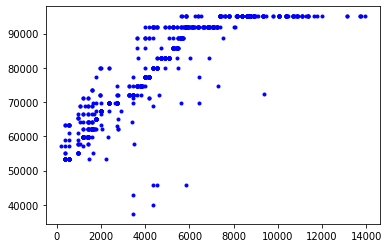

In [13]:
import matplotlib.pyplot as plt

plt.plot(police_officers['Tenure'], police_officers['Current Annual Salary'], 'b.')
plt.show()

This data looks much better and might be a good fit for a linear model. There do seem to be some obvious pay bands and an overall salary cap just over $90,000.

Another interesting salary-related datapoint is the actual gross pay that the officer received over the course of the year. Where the salary is promised pay, the gross salary is actual pay including overtime and subtracting days of unpaid leave and days before the officer started work (if the officer started in 2017).

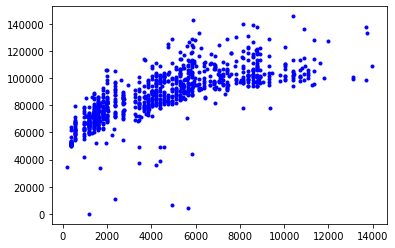

In [14]:
import matplotlib.pyplot as plt

plt.plot(police_officers['Tenure'], police_officers['2017 Gross Pay Received'], 'b.')
plt.show()

Here we can see more pronounced bands, but they aren't pay bands. The bands are groups of officers with the same tenure. Likely this is a class of officers starting at the same time. Also, most people start a new job on Mondays.

So which do we want to try to predict? Salary is likely more predictable since gross pay can be affected by an individual's willingness to perform overtime work.

A quick look at a correlation matrix indicates that we'd have better luck predicting salary also.

In [15]:
police_officers[['Tenure', 'Current Annual Salary', '2017 Gross Pay Received']].corr()

,Tenure,Current Annual Salary,2017 Gross Pay Received
Tenure,1.000000,0.895050,0.744854
Current Annual Salary,0.895050,1.000000,0.826263
2017 Gross Pay Received,0.744854,0.826263,1.000000


## k-Fold Cross Validation

### Create a Pipeline

For this lab we are going to use the [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) to find our regression line. Before we do that it is a good idea to scale our feature data using the [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Since we'll be using k-fold cross validation for exploring our model we can make it easier for ourselves to perform the data preprocessing and model fitting by using a `Pipeline`.

In [16]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

estimator = Pipeline(
  steps=[
    ['scale', StandardScaler()],
    ['regressor', SGDRegressor(random_state=562)],
  ]
)

### Shuffle the Data

We will also want to shuffle our data before sending it into the cross validation function.

In [17]:
police_officers = police_officers.sample(frac=1.0, random_state=324)
police_officers.head()

,Full Name,Gender,Current Annual Salary,2017 Gross Pay Received,2017 Overtime Pay,Department,Department Name,Division,Assignment Category,Employee Position Title,Position Under-Filled,Date First Hired,Tenure
1221,"Calafos, Michael W.",M,95084.42,102131.84,3297.63,POL,Department of Police,PSB 5th District Patrol,Fulltime-Regular,Police Officer III,NaN,06/13/1994,8603
7137,"Reyes, Laura E.",F,91869.00,91258.55,346.42,POL,Department of Police,PSB 6th District Patrol,Fulltime-Regular,Police Officer III,NaN,09/29/1997,7399
2149,"Denston, William B.",M,62020.00,68118.86,6452.02,POL,Department of Police,PSB 4th District Patrol,Fulltime-Regular,Police Officer III,Police Officer II,08/12/2013,1603
278,"Apelquist, Kristina J.",F,91869.00,111162.12,16714.81,POL,Department of Police,PSB 3rd District Patrol,Fulltime-Regular,Police Officer III,NaN,07/19/2004,4914
3973,"Horwitz, Charles W.",M,69762.00,85436.79,10898.07,POL,Department of Police,ISB Criminal Investigations Division 3rd Distr...,Fulltime-Regular,Police Officer III,NaN,07/12/2010,2730


### Calculate Scores

Now we can calculate our cross validation scores. We'll use the `cross_val_score` function which uses k-Fold cross validation by default.

We pass the function:

1. Estimator (it will be trained k-times)
1. Feature data
1. Target data
1. The number of folds.

In the case below we choose 5 folds, which holds out 20% of our data for testing and trains on 80% of the data. Other common values are 10 folds and even 4 folds. There isn't really a correct answer here as to the number of folds to use. The more folds, the more iterations of training and scoring, so your data size and cost of processing might dictate less folds. Above 10 folds isn't very beneficial because of the chances of your testing data for any given fold being very different from your training data increases, so you might not get an accurate view of your model's performance.

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    estimator,
    police_officers[['Tenure']],
    police_officers['Current Annual Salary'],
    cv=5
)

scores

array([0.78748878, 0.81152052, 0.81349627, 0.80026603, 0.77298398])

You can see after scoring the model with 5 folds we get 5 scores. Since we used an [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) the score is a r-squared score. Different models return different scores.

We can now take the mean of the scores to get a more balanced view of our model's performance.

In [19]:
scores.mean()

0.7971511172298218

### Comparing to Standard Test/Train Splitting

Let's compare our mean r-squared score to the score that we would have gotten from a standard test/train split of data.

In [20]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

estimator = Pipeline(
  steps=[
    ['scale', StandardScaler()],
    ['regressor', SGDRegressor(random_state=343)],
  ]
)

X_train, X_test, y_train, y_test = train_test_split(
    police_officers[['Tenure']], 
    police_officers['Current Annual Salary'], 
    test_size=0.2, 
    random_state=1234
)

estimator.fit(X_train, y_train)
estimator.score(X_test, y_test)

0.7108792353847615

In this case, at least when this colab was created, the mean cross validation score was actually higher than the individual test score. This won't always be the case and depending on the random states and number of times that you ran each code cell, might not be true.
 
What does the difference between the cross validation score and hold-out score tell us?
 
If the cross validation score is higher, then it means that our model probably performs better on unknown/new data than we would have thought by simply doing holdout.
 
If the cross validation score is lower than our model is likely to just be too well adjusted to the single set of holdout test data.
 
The cross validation score gives us a better idea of how our model would actually perform that the single hold-out score.

### Next Steps

We now have a mean cross validation score and have some idea of how our model will perform, so what's next?
 
There are a few options:
 
* Train the model on the entire dataset.
* Train the model on a subset of the dataset.
 
The first option isn't too bad, but it does still expose you to a slight risk that your model will end up overfitting. Since you are training with all of the data there is no way to go back and do one last check to ensure that your model is sane.
 
The second option is preferred. In this case, you still do a train-test split first. Then you perform cross validation on just the training data. Once you get the cross validation score you then train a new model on just the training data and do one final sanity check using the testing data.

In [21]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    police_officers[['Tenure']], 
    police_officers['Current Annual Salary'], 
    test_size=0.2, 
    random_state=1234
)

scores = cross_val_score(estimator, X_train, y_train, cv=5)

estimator = Pipeline(
  steps=[
    ['scale', StandardScaler()],
    ['regressor', SGDRegressor(random_state=343)],
  ]
)

estimator.fit(X_train, y_train)
score = estimator.score(X_test, y_test)

print(f'cross validation score (min): {scores.min()}')
print(f'cross validation score: {scores.mean()}')
print(f'final score {score}')

cross validation score (min): 0.7907099519582551
cross validation score: 0.8211850398220829
final score 0.7108792353847615


In this case again the cross validation score differs quite a bit from our cross validation score. This hints that we still might be overfitting to our training data and not generalizing well despite our cross validation score.

# Resources

* [scikit-learn Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

# Exercises

## Exercise 1

`cross_val_score` isn't limited to k-fold validation. It can perform many other splits on the data.
 
Use the [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) in `cross_val_score` instead of k-fold.
 
Set the parameters to:
 
* 5 splits
* 30% test size
* 56789 random state
 
Calculate the mean of the returned scores and store the mean in a variable called `mean_score`.

### Student Solution

In [22]:
n_samples = X_train.shape[0]
n_samples

725

In [23]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(
    police_officers[['Tenure']], 
    police_officers['Current Annual Salary'], 
    test_size=0.2, 
    random_state=1234
)

estimator = Pipeline(
  steps=[
    ['scale', StandardScaler()],
    ['regressor', SGDRegressor(random_state=343)],
  ]
)

ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=56789)

scores = cross_val_score(estimator, X_train, y_train, cv=ss)

mean_score = scores.mean()
mean_score

0.8252315489312142

## Exercise 2

In classification problems we may have unbalanced classes and want an even distribution of those classes in our training and testing data. This is called *stratification* and for classification problems scikit-learn provides the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) splitter. This balances our target data across folds.

Using the [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) create an [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) and run stratified cross validation over the digit targets.

Cross validate over 5 folds. Save the mean validation score in a variable called `mean_score`.

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import datasets
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import linear_model
digits_bunch =datasets.load_digits()

FEATURES = [x for x in range(64)]

digits = pd.DataFrame(digits_bunch['data'], columns=FEATURES)
digits['digit'] = digits_bunch['target']

In [25]:
estimator = Pipeline(
  steps=[
    ['scale', StandardScaler()],
    ['classifier', SGDClassifier()],
  ]
)

X = digits[FEATURES]
y = digits['digit']

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X,y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scores = cross_val_score(estimator, X_train, y_train, cv = skf)
mean_score = scores.mean()
mean_score


0.9218023132510316

## Exercise 3: Challenge (Ungraded)

There are times when we have insights about our data that we can feed our model. In some cases we can are aware of tranches in the data that have different characteristics and we'd like those characteristics reflected in our testing and training data.
 
In classification problems we may have unbalanced classes and want an even distribution of those classes in our training and testing data. This is called *stratification* and for classification problems scikit-learn provides the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) splitter. This balances our target data across folds.
 
However, there are other times when we need to balance our feature data across folds. Thinking about the salary data we have delt with in this colab, the [gender pay gap](https://en.wikipedia.org/wiki/Gender_pay_gap) comes to mind.
 
Let's see if we can find any evidence of a gap. First let's see the distribution of female and male officers.

In [26]:
police_officers.groupby(by='Gender')['Gender'].count()

Gender
F    192
M    715
Name: Gender, dtype: int64

We have about 26% females.

Now we can calculate an average salary by years tenure.

In [27]:
max_years = int(police_officers['Tenure'].max() / 365) + 1

bins = list(range(0, 365*max_years+1, 365))

labels = list(range(0, max_years))

police_officers['Tenure Years'] = pd.cut(police_officers['Tenure'], bins=bins, labels=labels)

police_officers.sample(10)[['Tenure', 'Tenure Years']]

,Tenure,Tenure Years
5101,1995,5
4455,10703,29
6766,5089,13
7127,2730,7
377,4067,11
6931,1799,4
5296,9310,25
3744,4186,11
40,5278,14
7412,5446,14


And finally, we can see on average if there is a gap.

In [28]:
females = police_officers[police_officers['Gender'] == 'F'].groupby(by='Tenure Years')['Current Annual Salary'].mean()
males = police_officers[police_officers['Gender'] == 'M'].groupby(by='Tenure Years')['Current Annual Salary'].mean()
(females-males).mean()

-1278.087011845095

In this case we see that there is over a $1000 gap in average salary based on years tenure.
 
If we want this reflected in our model we need to split the data in each of our folds. Unfortunately, this isn't quite as easy as stratifying target data.
 
There are a few approaches. One is to pre-split the data and use the [PredefinedSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit) class to identify test folds per iteration of cross validation.
 
Another is to write a custom [CV Splitter](https://scikit-learn.org/stable/glossary.html#term-cv-splitter) and implement `split` and `get_n_splits`.
 
In this challenge you are tasked with creating a 5-split CV Splitter or PredefinedSplit that keeps the feature data roughly 3:1 male:female.

### Student Solution

In [29]:
# Your code goes here
from sklearn.model_selection import PredefinedSplit

# myCViterator = []
# for i in range(nFolds):
#     trainIndices = police_officers[ police_officers['Gender']!="" ].index.values.astype(int)
#     testIndices =  police_officers[ police_officers['Gender']==i ].index.values.astype(int)
#     myCViterator.append( (trainIndices, testIndices) )

# police_officers['Gender_Modified'] = police_officers['Gender'].apply(lambda x: -1 if x == 'F' else 0)
# police_officers['Gender_Modified'].value_counts()

# [police_officers['Gender_Modified'] == 0][0:237] = 'M1'
# police_officers[police_officers['Gender_Modified'] == 0][0:237] = 'M2'
# police_officers[police_officers['Gender_Modified'] == 0][0:237] = 'M3'
# police_officers['Gender_Modified']
# test_fold = [(0 if police_officers['Gender'] == 'F') or (1 if police_officers['Gender'] == 'M')]
# test_fold

# ps = PredefinedSplit(test_fold)

# for train_index, test_index in ps.split():
#   print("TRAIN:", train_index, "TEST:", test_index)
#   X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#   y_train, y_test = y.iloc[train_index], y.iloc[test_index]